Internet Resources:

[Python Programming.net - machine learning episodes 39-42](https://pythonprogramming.net/hierarchical-clustering-mean-shift-machine-learning-tutorial/)

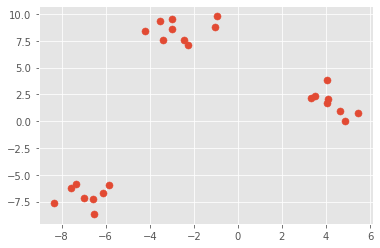

In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=25, centers=3, n_features=2, random_state=42)

##X = np.array([[1, 2],
##              [1.5, 1.8],
##              [5, 8],
##              [8, 8],
##              [1, 0.6],
##              [9, 11],
##              [8, 2],
##              [10, 2],
##              [9, 3]])


##plt.scatter(X[:, 0],X[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)
##plt.show()

#X = np.array([[-5, -4], [4,5], [3,-2], [-2,1]])

colors = 10*["g","r","c","b","k"]
plt.scatter(X[:,0], X[:,1], s=50)
plt.show()

The goal is to find clusters in the dataset. The first implementation of this algorithm still requires the user to input a radius parameter.

**Training algorithm for mean shift with fixed bandwitdth**

    - 1. at start every data point is a centroid

     Repeat until optimized: 
         for every centroid:
            - 2. for every data point: calculate distance to centroid 
            - 3. new centroid = mean of all data points where distance of centroid and data point < radius

**Prediction**  
    - query is classified as class of nearest centroid

![](notes_screenshots/MeanShift1.png)

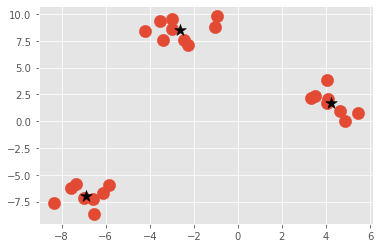

In [2]:
# mean shift without dynamic bandwidth
class Mean_Shift_With_Fixed_Bandwidth:
    def __init__(self, radius):
        self.radius = radius
        
        
    def fit(self, data):
        centroids = {}
        
        # 1. every data point is initialized as centroid
        for i in range(len(data)):
            centroids[i] = data[i]
            
        # Repeat until optimized 
        while True:
            new_centroids = []
            
            # for every centroid 
            for i in centroids: # i is centroid index
                in_bandwidth = [] # list of all data points that are within a proximity of self.radius of centroid 
                centroid = centroids[i]
                
                # 2. for every data point: calculate distance to centroid 
                for featureset in data:
                    if np.linalg.norm(featureset-centroid) < self.radius:
                        in_bandwidth.append(featureset)
                
                # 3. new centroid = mean of all data points where distance of centroid and data point < self.radius
                new_centroid = np.average(in_bandwidth,axis=0)
                new_centroids.append(tuple(new_centroid)) # casts nparray to tuple
            
            # get rid of any duplicate centroids
            uniques = sorted(list(set(new_centroids)))
            
            # need previous centroids to check if optimized
            prev_centroids = dict(centroids)
            
            # set new centroids (=uniques) as current centroids
            centroids = {i:np.array(uniques[i]) for i in range(len(uniques))}
            
            # is optimized if centroids are not moving anymore
            optimized = True
            for i in centroids:
                if not np.array_equal(centroids[i], prev_centroids[i]):
                      optimized = False
                if not optimized:
                    break
            if optimized:
                break

        self.centroids = centroids
            
            
mean_shift = Mean_Shift_With_Fixed_Bandwidth(radius=3)
mean_shift.fit(X)

mean_shift_centroids = mean_shift.centroids

plt.scatter(X[:,0], X[:,1], s=150)

for c in mean_shift_centroids:
    plt.scatter(mean_shift_centroids[c][0], mean_shift_centroids[c][1], color='k', marker='*', s=150)

plt.show()

Mean shift with dynamic bandwidth differs from the implementation with fixed bandwidth in that it no longer requires a set bandwidth from the user. Instead it estimates a fitting radius. Additionally when calculating new means, each data point is weighted depending how near or far its away from the current mean.

**Training algorithm for mean shift with dynamic bandwitdth**

    - 1. at start every data point is a centroid
    - 2. estimate  radius:
        radius = mean(distance of every datapoint to mean of entire dataset)
        
     Repeat until optimized: 
         for every centroid:
            - 3. for every data point: calculate distance to centroid and assign weight to it. 
            - 4. calculate new centroid: new centroid = mean of all weighted  data points within radius            
            
**Prediction:**  
    - query is classified as class of nearest centroid

![](notes_screenshots/MeanShift2.png)

radius: 7.7154956944971165
Converged @ iteration  4
{0: array([-6.90317619, -6.89931766]), 1: array([-2.73110315,  8.49395546]), 2: array([4.1924512 , 1.71794089])}


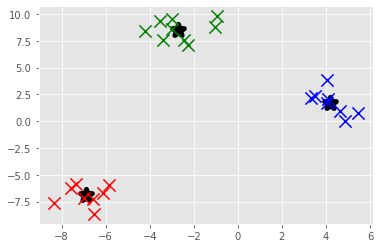

In [3]:
class Mean_Shift_With_Dynamic_Bandwith:
    def __init__(self, radius_norm_step = 100):
        self.radius_norm_step = radius_norm_step # controls how many discrete wights are used
    
    def fit(self,data,max_iter=1000, weight_fkt=lambda x : x**2): # weight_fkt: how to weight distances 
        # 1. every data point is a centroid
        self.centroids = {i:data[i] for i in range(len(data))}
        
        # 2. radius calculation
        mean_of_entire_data = np.average(data,axis=0) 
        # all_distances= list of distances for ever data point to mean of entire date
        all_distances = [np.linalg.norm(datapoint-mean_of_entire_data) for datapoint in data]
        self.radius = np.mean(all_distances)
        print("radius:", self.radius)
        
        # list of discrete weights: let n = self.radius_norm_step -> weights = [n-1,n-2,n-3,...,2,1]
        weights = [i for i in range(self.radius_norm_step)][::-1] # [::-1] inverts list
        
        # do until convergence
        for count in range(max_iter):
            new_centroids = []
            
            # for each centroid
            for centroid_class in self.centroids:
                centroid = self.centroids[centroid_class]
                
                # 3. weigh data points
                new_centroid_weights = []
                for data_point in data:
                    weight_index = int(np.linalg.norm(data_point - centroid)/self.radius * self.radius_norm_step)
                    new_centroid_weights.append(weight_fkt(weights[min(weight_index, self.radius_norm_step)-1]))
                    
                # calculate new centroid
                # w: weight, x: sample
                new_centroid = np.sum([ w*x for w, x in zip(new_centroid_weights, data)], axis=0) / np.sum(new_centroid_weights)
                new_centroids.append(tuple(new_centroid))
                                                    
            uniques = sorted(list(set(new_centroids)))
            
            #remove non uniques
            for i in uniques:
                for ii in [i for i in uniques]:
                    # centroid is near enough to another centroid to merge
                    if not i == ii and np.linalg.norm(np.array(i)-np.array(ii)) <= self.radius/self.radius_norm_step:
                        uniques.remove(ii)
                        
            
            prev_centroids = dict(self.centroids)
            self.centroids = {}
            for i in range(len(uniques)):
                self.centroids[i] = np.array(uniques[i])
                    
            # check if optimized
            optimized = True
            for i in self.centroids:
                if not np.array_equal(self.centroids[i], prev_centroids[i]):
                    optimized = False

            if optimized:
                print("Converged @ iteration ", count)
                break
               
        # classify training data
        self.classifications = {i:[] for i in range(len(self.centroids))}
        for featureset in data:
            #compare distance to either centroid
            distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
            classification = (distances.index(min(distances)))

            # featureset that belongs to that cluster
            self.classifications[classification].append(featureset)


    def predict(self,data):
        #compare distance to either centroid
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = (distances.index(min(distances)))
        return classification

            
clf = Mean_Shift_With_Dynamic_Bandwith()
clf.fit(X)

centroids = clf.centroids
print(centroids)

colors = 10*['r','g','b','c','k','y']

for classification in clf.classifications:
    color = colors[classification]
    for featureset in clf.classifications[classification]:
        plt.scatter(featureset[0],featureset[1], marker = "x", color=color, s=150, linewidths = 5, zorder = 10)

for c in centroids:
    plt.scatter(centroids[c][0],centroids[c][1], color='k', marker = "*", s=150, linewidths = 5)


plt.show()